<a href="https://colab.research.google.com/github/nicolastibata/MINE_4210_ADL_202520/blob/main/labs/Laboratorio_10/MINE__4210_ADL_202520_L10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 10: VAE + GAN**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Taller 5: Bono](#scrollTo=JTKc52_Wvs_N)<br>

### **Contexto y Objetivos**

- Se requiere ampliar la cantidad de imágenes de tornillos dependiendo de los modelos aplicados, entender como funciona cada algoritmo y sus principales diferencias en código.

### **Objetivos**
1. Construir una Red Neuronal basada en una VAE (Variational Auto-Encoder) para llevar a cabo generación de imágenes al set de datos inicial.
2. Desarrollar en el taller bono una arquitectura GAN al mismo set de datos. Luego poder comparar rendimientos de ambos modelos y concluir el mejor para esta aplicación.



**Datos:** [screw-dataset](https://www.kaggle.com/datasets/ruruamour/screw-dataset/data)

### **1. Introducción a los datos**

In [18]:
!pip install kaggle -q
!pip install keras-tuner -q

In [19]:
import os
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras


from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras import backend as K
from keras import applications
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from google.colab import files
from google.colab import userdata

In [20]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d ruruamour/screw-dataset
!unzip "screw-dataset.zip"

Dataset URL: https://www.kaggle.com/datasets/ruruamour/screw-dataset
License(s): CC-BY-NC-SA-4.0
screw-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  screw-dataset.zip
replace license.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
# Cargar el dataset de imágenes
image_size = (128, 128)  # Tamaño deseado para las imágenes
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    f"/content/train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.2,
    subset="training",
    seed=71
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    f"/content/test",
    image_size=image_size,
    batch_size=batch_size,
    label_mode=None,
    validation_split=0.2,
    subset="validation",
    seed=71
)

Found 300 files.
Using 240 files for training.
Found 180 files.
Using 36 files for validation.


In [22]:
# Normalizar las imágenes
train_ds = train_ds.map(lambda x: x / 255.0)
test_ds = test_ds.map(lambda x: x / 255.0)

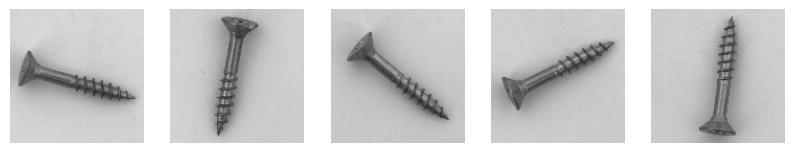

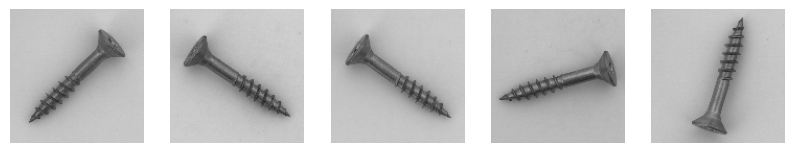

In [23]:
def display_sample_images(dataset, num_samples=5):
    # Tomar un batch de imágenes del dataset
    for images in dataset.take(1):  # Solo tomar un batch
        plt.figure(figsize=(10, 10))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            plt.imshow(images[i])
            plt.axis('off')
        plt.show()

# Mostrar algunas imágenes de train_ds
display_sample_images(train_ds)

# Mostrar algunas imágenes de val_ds
display_sample_images(test_ds)

### **2. Preparación y Modelamiento**

#### **Modelo VAE**

In [7]:
# Preparar el dataset para entrenamiento y validación
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
# Define el encoder
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(128, 128, 3))  # Imagen de entrada
    x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    return models.Model(inputs, [z_mean, z_log_var], name="VAE_Encoder")

# Define el decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(latent_inputs)
    x = layers.Dense(32 * 32 * 64, activation='relu')(x)
    x = layers.Reshape((32, 32, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name="VAE_Decoder")

# Definir el modelo VAE
latent_dim = 128  # Dimensión del espacio latente
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Función de muestreo para VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Definir el modelo VAE
z_mean, z_log_var = encoder.output
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
vae_output = decoder(z)

vae = models.Model(encoder.input, vae_output, name="VAE")

# Compilar el modelo
vae.compile(optimizer='adam', loss='mse')

In [9]:
vae.summary()

Model: "VAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │     18,496 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  8,388,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VAE_Decoder         │ (None, 128, 128,  │  8,526,915 │ lambda[0][0]      │
│ (Functional)        │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,968,067 (64.73 MB)

 Trainable params: 16,968,067 (64.73 MB)

 Non-trainable params: 0 (0.00 B)

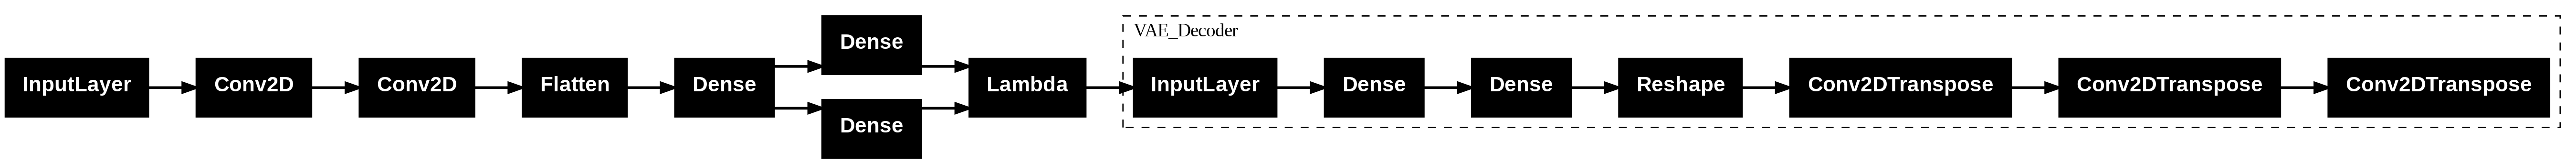

In [10]:
plot_model(vae, expand_nested=True, rankdir='LR')

In [11]:
def vae_loss(x, x_decoded_mean, z_mean, z_log_var):
    # Pérdida de reconstrucción (Error cuadrático medio)
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_decoded_mean), axis=[1, 2, 3]))

    # Pérdida de divergencia KL (entre la distribución de la representación latente y la normal estándar)
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

    # Pérdida total
    total_loss = reconstruction_loss + kl_loss
    return total_loss

In [12]:
# Listas para almacenar las pérdidas por cada época
losses = []

epochs = 1000
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Inicializar la pérdida para esta época
    epoch_loss = 0

    for images in train_ds:
        with tf.GradientTape() as tape:
            # Codificar las imágenes
            z_mean, z_log_var = encoder(images)
            z = sampling([z_mean, z_log_var])

            # Decodificar las representaciones latentes
            x_decoded_mean = decoder(z)

            # Calcular la pérdida
            loss = vae_loss(images, x_decoded_mean, z_mean, z_log_var)

        # Obtener los gradientes y actualizar los pesos
        grads = tape.gradient(loss, vae.trainable_variables)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_variables))

        # Acumulamos la pérdida de esta iteración en la variable de la época
        epoch_loss += loss.numpy()

    # Promediar la pérdida de todas las iteraciones de la época
    epoch_loss /= len(train_ds)

    # Almacenar la pérdida de esta época
    losses.append(epoch_loss)

    # Imprimir la pérdida por época
    print(f"Loss: {epoch_loss}")

Epoch 1/1000
Loss: 2740.653076171875
Epoch 2/1000
Loss: 937.93359375
Epoch 3/1000
Loss: 731.2468872070312
Epoch 4/1000
Loss: 692.1122436523438
Epoch 5/1000
Loss: 669.5123291015625
Epoch 6/1000
Loss: 667.2158203125
Epoch 7/1000
Loss: 666.1083374023438
Epoch 8/1000
Loss: 658.9121704101562
Epoch 9/1000
Loss: 648.6865234375
Epoch 10/1000
Loss: 652.2634887695312
Epoch 11/1000
Loss: 647.3208618164062
Epoch 12/1000
Loss: 640.8366088867188
Epoch 13/1000
Loss: 632.286865234375
Epoch 14/1000
Loss: 616.9593505859375
Epoch 15/1000
Loss: 554.7388916015625
Epoch 16/1000
Loss: 509.9383544921875
Epoch 17/1000
Loss: 454.386962890625
Epoch 18/1000
Loss: 421.7954406738281
Epoch 19/1000
Loss: 404.49664306640625
Epoch 20/1000
Loss: 407.3931579589844
Epoch 21/1000
Loss: 390.5535583496094
Epoch 22/1000
Loss: 378.1712341308594
Epoch 23/1000
Loss: 374.18231201171875
Epoch 24/1000
Loss: 361.24334716796875
Epoch 25/1000
Loss: 350.5202941894531
Epoch 26/1000
Loss: 344.76904296875
Epoch 27/1000
Loss: 336.627319335

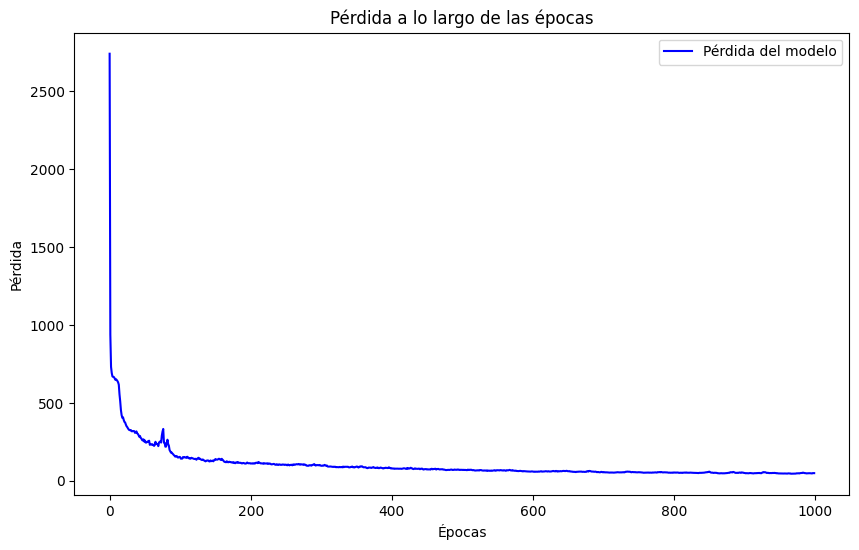

In [13]:
# Graficar la pérdida a lo largo de las épocas
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), losses, label='Pérdida del modelo', color='b')
plt.title('Pérdida a lo largo de las épocas')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

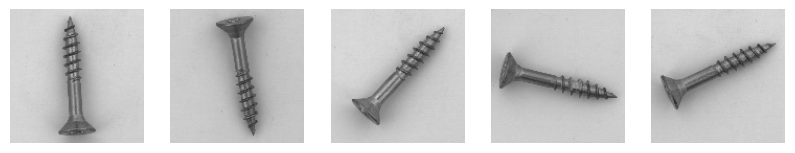

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


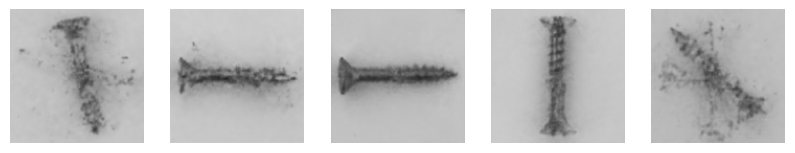

In [36]:
def generate_images(decoder, num_images=5, latent_dim=128):
    random_latents = np.random.normal(size=(num_images, latent_dim))  # Muestra de una normal estándar
    generated_images = decoder.predict(random_latents)

    # Mostrar las imágenes generadas
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

# Imagenes del set original
display_sample_images(train_ds)

# Función generadora de imágenes
generate_images(decoder)

### **3. Taller 5: Bono**


Instrucciones

1. El archivo a presentar debe ser en formato .ipynb o HTML con sus celdas ejecutadas. Celdas sin ejecutar no podrán ser evaluadas.
2. El nombre del archivo debe ser taller_5_{Apellido_Nombre}_{Apellido_Nombre} de cada integrante del equipo.
3. Las entregas solo se hacen a través de Bloque Neón.

------


1. Aplique aumentación de imágenes al set de datos inicial y vuelva a entrenar el modelo VAE del laboratorio, ¿nota alguna diferencia? Documente los resultados.

2. Construya un modelo GAN (Generative Adversarial Network) para generación de imagenes. Defina la sección discriminadora y la generadora y entrene el modelo con el dataset aumentado del punto 1.

3. Compare ambos modelos, *modelo del punto 1 (VAE) y modelo del punto 2 (GAN)* con Frechet Inception Distance y en una tabla comparativa documente los resultados.